![Machine Learning Lab](banner.jpg)

# Laboratorio 4

## Objetivos

1. **Comprender los modelos de árboles de decisión**: Explorar cómo funcionan los árboles de decisión, Random Forest y XGBoost, analizando sus diferencias en términos de rendimiento y explicabilidad.

2. **Aplicar técnicas de preprocesamiento de datos**: Implementar la limpieza, transformación y codificación de datos para mejorar la calidad del conjunto de datos antes del entrenamiento de modelos.

3. **Evaluar y visualizar la frontera de decisión**: Analizar cómo los hiperparámetros, especialmente max_depth, afectan la frontera de decisión en los árboles de decisión, utilizando herramientas como SHAP para interpretar la importancia de las variables.



### Instalación de librerías

Antes de comenzar, instalamos las librerías para utilizar árboles de decisión y para la explicabilidad de los mismos.

In [5]:
!pip3 install shap xgboost --quiet
!pip3 install ydata-profiling --quiet

You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


### Descargar dataset

En esta ocasión usaremos un dataset con información de los pasajeros del Titanic, cuyo objetivo es predecir si una determinada persona sobrevivió o no al accidente.

Ver [Titanic Dataset](https://www.kaggle.com/datasets/yasserh/titanic-dataset)

In [2]:
!mkdir -p datasets
!curl -L -o datasets/titanic-dataset.zip https://www.kaggle.com/api/v1/datasets/download/yasserh/titanic-dataset
!unzip -o datasets/titanic-dataset.zip -d datasets/titanic-dataset
!ls datasets/titanic-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 22564  100 22564    0     0  21229      0  0:00:01  0:00:01 --:--:-- 21229
Archive:  datasets/titanic-dataset.zip
  inflating: datasets/titanic-dataset/Titanic-Dataset.csv  
Titanic-Dataset.csv


### Importar librerías

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import shap
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from ydata_profiling import ProfileReport
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

### Carga de datos

In [8]:
data = pd.read_csv("datasets/titanic-dataset/Titanic-Dataset.csv")

### Perfilamiento de datos

Antes de entrenar cualquier modelo revisemos si hay algo inusual con los datos creando un reporte de los datos con yDataProfiling.

In [9]:
profile = ProfileReport(data, title="Titanic Dataset")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:00<00:00, 5340.79it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Preparación de datos

Vamos a remover las variables que no nos dan información relevante, como `PassengerId`, `Name`, `Ticket` y `Cabin`. También completaremos los datos faltantes con el promedio o la moda dependiendo de si la columna es categórica o númerica.


In [10]:
data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)

### Separación de los datos

Para este laboratorio nuestra variable objetivo será `Survived`. También separaremos nuestros datos en sets de entrenamiento y prueba.


In [11]:
target_column = 'Survived'

X = data.drop(columns=[target_column])
y = data[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

### Preprocesamiento de datos

Tal  como indicamos previamente, imputamos los datos, y codificamos las variables categóricas con `OneHotEncoder`

In [12]:
categorical_features = X_train.select_dtypes(include=['object']).columns
numerical_features = X_train.select_dtypes(include=['number']).columns

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numerical_features),
        ('cat', cat_pipeline, categorical_features)
    ],
    remainder='passthrough'
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

num_col_names = numerical_features.tolist()
encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
cat_col_names = encoder.get_feature_names_out(categorical_features).tolist()
final_column_names = num_col_names + cat_col_names

X_train_processed = pd.DataFrame(X_train_processed, columns=final_column_names)
X_test_processed = pd.DataFrame(X_test_processed, columns=final_column_names)

In [13]:
# Observamos los datos procesados y las columnas (features) que usaremos para el entrenamiento de los modelos.

X_train_processed.head()

Pclass   Age  SibSp  Parch     Fare  Sex_female  Sex_male  Embarked_C  \
0     2.0  43.0    1.0    1.0  26.2500         0.0       1.0         0.0   
1     1.0  32.0    0.0    0.0  76.2917         1.0       0.0         1.0   
2     3.0  16.0    0.0    0.0   7.7333         1.0       0.0         0.0   
3     1.0  47.0    0.0    0.0  25.5875         0.0       1.0         0.0   
4     1.0  34.0    0.0    0.0  26.5500         0.0       1.0         0.0   

   Embarked_Q  Embarked_S  
0         0.0         1.0  
1         0.0         0.0  
2         1.0         0.0  
3         0.0         1.0  
4         0.0         1.0

### Modelos de árboles

En este laboratorio explicaremos algunos modelos y la diferencia entre estos. Estos modelos son:

- Árbol de Decisión
- Random Forest
- AdaBoost
- XGBoost

Para esto definiremos funciones que usaremos múltiples veces


In [14]:

def full_model_report(model, X_train, X_test, y_train, y_test, skip_shap=False):
    """
    Genera un reporte completo del rendimiento de un modelo de clasificación.

    Args:
        model: Modelo de clasificación a evaluar.
        X_train: Datos de entrenamiento.
        X_test: Datos de prueba.
        y_train: Etiquetas de entrenamiento.
        y_test: Etiquetas de prueba.
        skip_shap (bool): Si True, omite análisis SHAP. Default False.

    Muestra métricas de clasificación, matriz de confusión y análisis SHAP.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.show()

    if skip_shap:
        return

    explainer = shap.Explainer(model, X_train)

    shap_vals = explainer(X_test)

    print(f"\nFeature Importance according to SHAP - {model.__class__.__name__}")
    print(shap_vals)

    shap.summary_plot(shap_vals, X_test, feature_names=X_test.columns)


### Árbol de Decisión

Comencemos con el modelo más simple: Árboles de decisión

              precision    recall  f1-score   support

           0       0.78      0.83      0.81       110
           1       0.70      0.64      0.67        69

    accuracy                           0.75       179
   macro avg       0.74      0.73      0.74       179
weighted avg       0.75      0.75      0.75       179



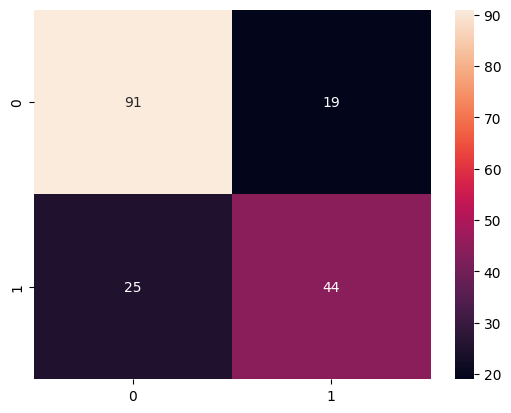


Feature Importance according to SHAP - DecisionTreeClassifier
.values =
array([[[-0.0945    ,  0.0945    ],
        [-0.3345    ,  0.3345    ],
        [-0.00666667,  0.00666667],
        ...,
        [ 0.01716667, -0.01716667],
        [ 0.        ,  0.        ],
        [ 0.00866667, -0.00866667]],

       [[-0.11286667,  0.11286666],
        [-0.00661667,  0.00661667],
        [ 0.02886111, -0.02886111],
        ...,
        [ 0.0258    , -0.0258    ],
        [ 0.        ,  0.        ],
        [ 0.00733333, -0.00733333]],

       [[-0.07283334,  0.07283333],
        [-0.16905556,  0.16905556],
        [-0.27205555,  0.27205556],
        ...,
        [ 0.01716667, -0.01716667],
        [-0.02366667,  0.02366667],
        [ 0.01716667, -0.01716667]],

       ...,

       [[-0.09294444,  0.09294444],
        [ 0.19433333, -0.19433334],
        [-0.00333333,  0.00333333],
        ...,
        [ 0.0045    , -0.0045    ],
        [ 0.        ,  0.        ],
        [ 0.002     , -0.002

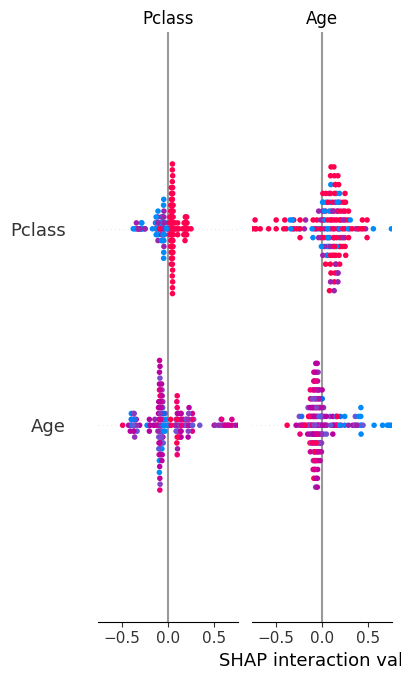

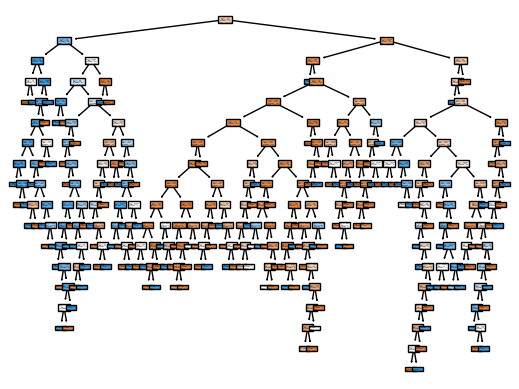

In [15]:
from sklearn.tree import plot_tree
%matplotlib inline

model_tree = DecisionTreeClassifier(random_state=55)
full_model_report(model_tree, X_train_processed, X_test_processed, y_train, y_test)
plot_tree(model_tree, filled=True)
plt.show()

### Random Forest

Ahora usamos `RandomForest`, un método de ensamble que entrena varios árboles de decisión en paralelo.

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       110
           1       0.78      0.65      0.71        69

    accuracy                           0.79       179
   macro avg       0.79      0.77      0.77       179
weighted avg       0.79      0.79      0.79       179



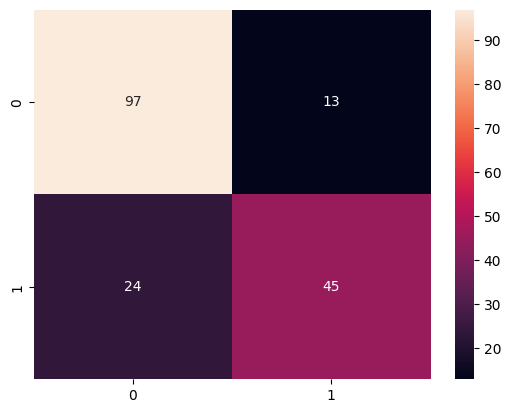


Feature Importance according to SHAP - RandomForestClassifier
.values =
array([[[-0.04874606,  0.04874606],
        [-0.18244395,  0.18244395],
        [-0.03851389,  0.03851389],
        ...,
        [ 0.01401708, -0.01401708],
        [-0.00029967,  0.00029967],
        [ 0.00278141, -0.00278141]],

       [[-0.14863964,  0.14863964],
        [ 0.0182785 , -0.0182785 ],
        [ 0.19378094, -0.19378095],
        ...,
        [ 0.01257864, -0.01257864],
        [ 0.00473363, -0.00473363],
        [ 0.01594358, -0.01594358]],

       [[-0.07045502,  0.07045502],
        [ 0.07713053, -0.07713053],
        [-0.03916726,  0.03916726],
        ...,
        [ 0.01537439, -0.01537439],
        [-0.00156372,  0.00156372],
        [ 0.00546326, -0.00546326]],

       ...,

       [[-0.0593009 ,  0.0593009 ],
        [ 0.10952985, -0.10952985],
        [-0.01139824,  0.01139824],
        ...,
        [ 0.0148185 , -0.0148185 ],
        [-0.00028056,  0.00028056],
        [ 0.00384239, -0.003

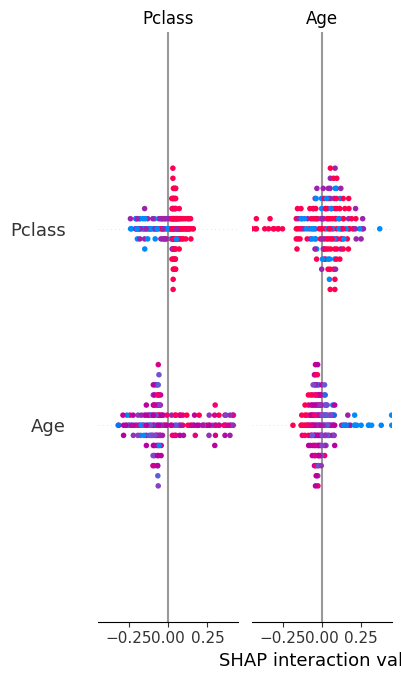

In [16]:
model_forest = RandomForestClassifier(n_estimators=100, random_state=55)
full_model_report(model_forest, X_train_processed, X_test_processed, y_train, y_test)

### AdaBoost Classifier

Ahora usamos `AdaBoostClassifier` un método de ensamble que combina múltiple clasificadores para formar un clasificador más fuerte de manera secuencial.

              precision    recall  f1-score   support

           0       0.79      0.85      0.82       110
           1       0.73      0.64      0.68        69

    accuracy                           0.77       179
   macro avg       0.76      0.75      0.75       179
weighted avg       0.77      0.77      0.77       179



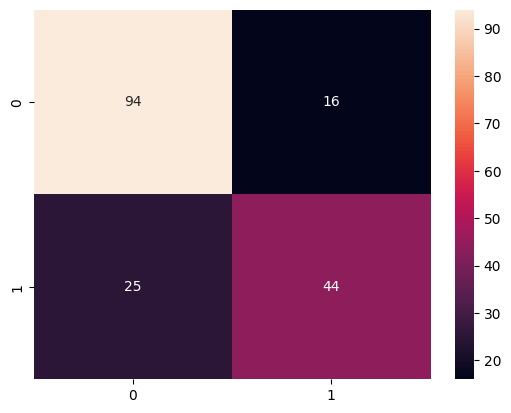

In [17]:
model_ada = AdaBoostClassifier(n_estimators=100, random_state=55)
full_model_report(model_ada, X_train_processed, X_test_processed, y_train, y_test, skip_shap=True)

### XGBoost Classifier

Finalmente usamos `XGBoost`, otro método de ensamble optimizado.

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       110
           1       0.80      0.68      0.73        69

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179



/Users/estefanialaverdebecerra/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [18:37:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


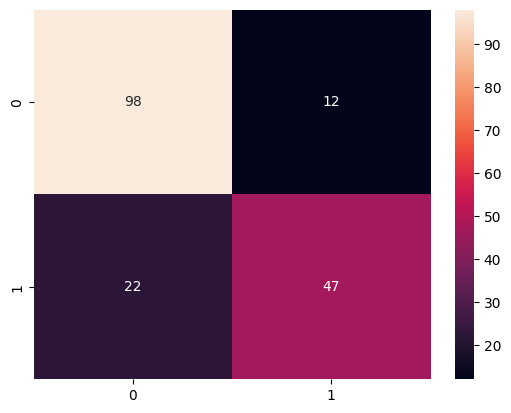


Feature Importance according to SHAP - XGBClassifier
.values =
array([[-4.49556521e-01,  5.72162991e-01,  2.50324742e-01, ...,
        -2.33020379e-01,  1.76530136e-02, -9.08302993e-02],
       [ 1.24375011e+00, -9.54613963e-01, -2.19342006e+00, ...,
        -1.80353327e-01, -1.67725083e-02, -1.10633221e-01],
       [ 1.14353064e+00, -1.06903471e+00,  4.81675194e-01, ...,
        -1.41831864e-01,  5.14011241e-02, -7.31326213e-03],
       ...,
       [ 2.99011284e-01, -9.29218468e-01,  2.20351797e-01, ...,
        -1.79096608e-02,  4.63755073e-02,  1.70531049e-02],
       [ 2.43827232e+00, -1.58152313e+00, -1.51886959e-03, ...,
        -1.26500767e-01,  4.38681537e-02, -7.96148353e-02],
       [-1.16385215e+00,  3.71484857e-01, -3.59189229e-01, ...,
        -1.76849167e-01, -2.41282496e-02, -3.13167248e-01]])

.base_values =
array([-1.01229347, -1.01229347, -1.01229347, -1.01229347, -1.01229347,
       -1.01229347, -1.01229347, -1.01229347, -1.01229347, -1.01229347,
       -1.01229347,

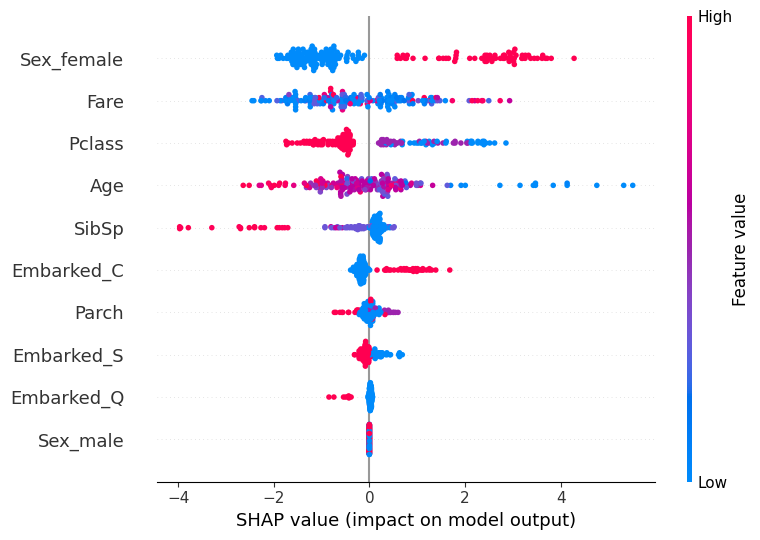

In [18]:
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=55)
full_model_report(model_xgb, X_train_processed, X_test_processed, y_train, y_test)

### Explicabilidad del modelo

Como podemos ver una de las mayores ventajas de los modelos de árboles, sea Random Forest, XGBoost o árboles simples, es su explicabilidad. Es relativamente fácil saber qué variables afectan el resultado esperado


### Hyper parámetros en árboles de decisión

A continuación, haremos una demostración de cómo el hiper-parámetro `max_depth` de un árbol de decisión afecta la frontera de decisión.

Para ver esto tomaremos como ejemplo dos árboles de decisión. Ambos construidos usando únicamente las columnas `Age` y `Pclass`. El primer árbol lo entrenamos con `max_depth=3` mientras que el segundo con `max_depth=10`. Luego para cada árbol graficamos su frontera de decisión (ilustrada por el color del background) y su estructura.



/var/folders/dj/ljhjywgx7050wg5x_690yv1c0000gn/T/ipykernel_27429/3286733685.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name, n)


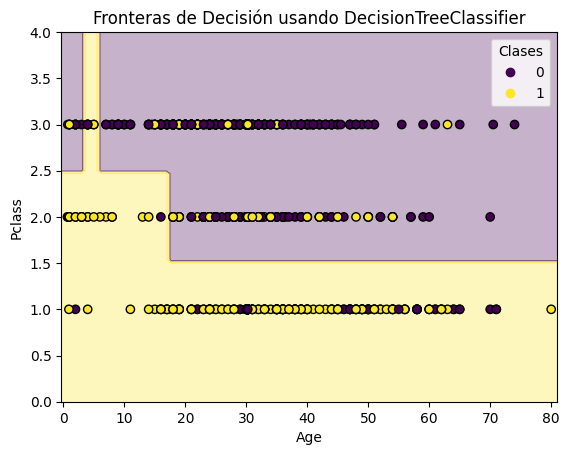

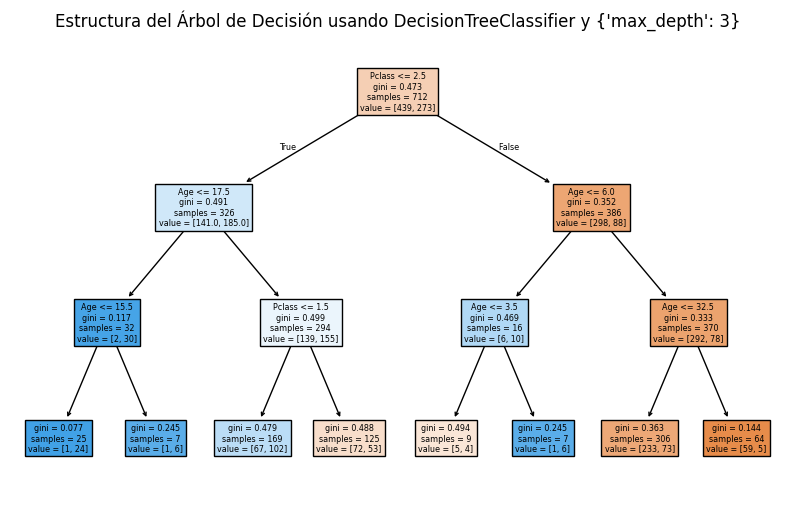

/var/folders/dj/ljhjywgx7050wg5x_690yv1c0000gn/T/ipykernel_27429/3286733685.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name, n)


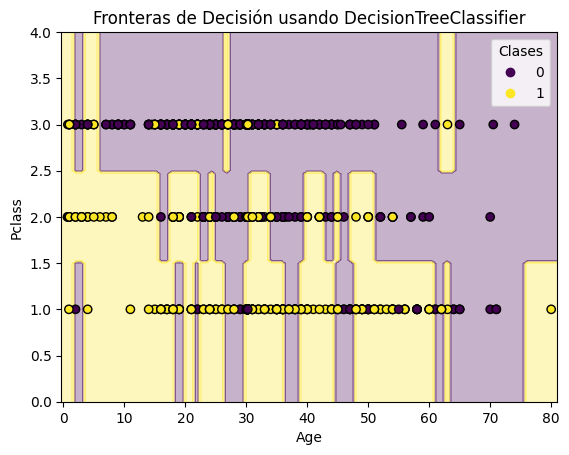

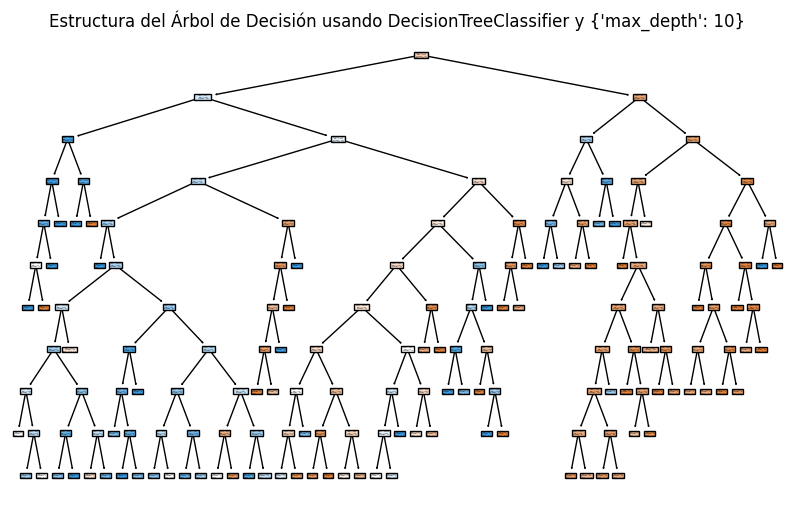

In [19]:
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

def generate_palette(n, cmap_name='viridis'):
    cmap = cm.get_cmap(cmap_name, n)
    return [mcolors.to_hex(cmap(i)) for i in range(n)]

def plot_class_boundaries(X_train_processed, y_train, column_1, column_2, model_class, **model_kwargs):
    """
    Grafica las fronteras de decisión de un modelo de clasificación basado en dos características
    seleccionadas de los datos de entrenamiento. Esta función ajusta el modelo dado en las
    columnas de características proporcionadas y visualiza las regiones de decisión, fronteras
    de clase y puntos de entrenamiento en un gráfico 2D.

    :param X_train_processed: DataFrame que contiene los datos de entrenamiento procesados.
    :param y_train: Las etiquetas objetivo correspondientes a los datos de entrenamiento.
    :param column_1: El nombre de la primera columna de características para graficar fronteras.
    :param column_2: El nombre de la segunda columna de características para graficar fronteras.
    :param model_class: La clase de clasificador a instanciar para ajuste y visualización.
    :param model_kwargs: Argumentos adicionales para inicializar la instancia del clasificador.
    :return: None
    """
    # Extraer solo las dos columnas especificadas
    X_train_selected = X_train_processed[[column_1, column_2]].values

    # Entrenar el modelo
    model = model_class(**model_kwargs)
    model.fit(X_train_selected, y_train)

    # Generar una malla de puntos
    x_min, x_max = X_train_selected[:, 0].min() - 1, X_train_selected[:, 0].max() + 1
    y_min, y_max = X_train_selected[:, 1].min() - 1, X_train_selected[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    # Predecir en la malla
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Generar paleta de colores
    unique_classes = np.unique(y_train)
    n_classes = len(unique_classes)
    colors = generate_palette(n_classes)
    cmap = ListedColormap(colors)

    # Graficar fronteras de decisión
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)

    # Graficar puntos de entrenamiento
    scatter = plt.scatter(X_train_selected[:, 0], X_train_selected[:, 1], c=y_train, cmap=cmap, edgecolor='k')

    # Etiquetas y título
    plt.xlabel(column_1)
    plt.ylabel(column_2)
    plt.title(f'Fronteras de Decisión usando {model_class.__name__}')

    # Agregar leyenda
    handles, labels = scatter.legend_elements()
    plt.legend(handles, labels, title="Clases")
    plt.show()

    if model_class == DecisionTreeClassifier:
        # graficar la estructura del árbol
        plt.figure(figsize=(10, 6))
        plot_tree(model, filled=True, feature_names=[column_1, column_2])
        plt.title(f'Estructura del Árbol de Decisión usando {model_class.__name__} y {model_kwargs}')
        plt.show()

plot_class_boundaries(X_train_processed, y_train, 'Age', 'Pclass', DecisionTreeClassifier, max_depth=3)
plot_class_boundaries(X_train_processed, y_train, 'Age', 'Pclass', DecisionTreeClassifier, max_depth=10)
